In [3]:
#Imports
import numpy as np
from pybrain.datasets import SequentialDataSet
from itertools import cycle
from pybrain.tools.shortcuts import buildNetwork
from pybrain.structure.modules import LSTMLayer
from pybrain.supervised import RPropMinusTrainer
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
##Error function
def error_in_prediction(predicted_sample, actual_next_sample):
    if type(predicted_sample) is list:
        predicted_sample = np.array(predicted_sample)
    if type(actual_next_sample) is list:
        actual_next_sample = np.array(actual_next_sample)
    error = np.mean(np.square(predicted_sample - actual_next_sample))
    return error

In [12]:
##Plotting function
def gen_state_iteration_plot(lstm_width, state_values, net, ds,\
        it_num, name, time, save=False, return_error=False):
    if save == True:
        #Required to clear the plots in case the function is used to save
        #the plots
        plt.cla()
    f, axarr = plt.subplots(2, 2, figsize=(10,10))
    for k in range(lstm_width):
        axarr[1,0].plot(state_values[k], label='State '+str(k+1))
        if lstm_width > 1:
            if k == 0:
                master_state = state_values[k]
            else:
                master_state = [sum(x) for x in zip(master_state,\
                    state_values[k])]
    if lstm_width > 1:
        axarr[1,0].plot(master_state, label='adding all states')
    if lstm_width < 5:
        axarr[1,0].legend(prop={'size':6})
    axarr[1,0].set_title('State values after '+str(it_num)+\
            ' training iterations')
    axarr[1,0].set_xlabel('Time steps')
    axarr[1,0].set_ylabel('Magnitude')

    current_input = []
    predicted_sample = []
    actual_next_sample = []
    for sample, target in ds.getSequenceIterator(0):
        current_input.append(sample[0])
        predicted_sample.append(net.activate(sample))
        actual_next_sample.append(target)

    #Calculating the error    
    error = error_in_prediction(predicted_sample, actual_next_sample)
    
    #calculating number of points
    numPoints = len(current_input)
    #Plotting the input, predicted output and actual output
    axarr[0,0].plot(time,current_input, label='Input')
    axarr[0,1].plot(time,predicted_sample,\
            label='Predicted sample')
    axarr[1,1].plot(time,actual_next_sample, \
        label = 'Actual next sample')
    axarr[0,0].set_xlabel('Time')
    axarr[0,0].set_ylabel('Magnitude')
    axarr[0,0].set_title('Input')
    axarr[0,1].set_xlabel('Time')
    axarr[0,1].set_ylabel('Magnitude')
    axarr[0,1].set_title('Predicted Sample')
    axarr[1,1].set_xlabel('Time')
    axarr[1,1].set_ylabel('Magnitude')
    axarr[1,1].set_title('Actual next Sample')
    if save == True:
        plt.savefig('../graphs/Error_testing/'\
                    +str(lstm_width)+'_'\
            +name+'_'+str(it_num)+'.png')
        plt.close()
        plt.clf()
    else:
        plt.show()
        
    if return_error == True:
        return error
    else:
        print "Error in prediction :"+str(error)

#### Sine curves

In [46]:
#Generating the training data for the LSTM
numPoints = 200
x = np.linspace(-10, 10, numPoints)
#generating random noise
magRandNoise = 0.6
noise = magRandNoise*np.random.normal(size=numPoints)
data = list(np.sin(x) + noise)
ds = SequentialDataSet(1,1)
for sample, next_sample in zip(data, cycle(data[1:])):
    ds.addSample(sample, next_sample)

In [78]:
#creating second dataset for testing
numPoints2 = 400
x2 = np.linspace(-20, 20, numPoints2)
#generating random noise
magRandNoise2 = 10
noise2 = magRandNoise*np.random.normal(size=numPoints2)
data2 = list(np.sin(x2) + noise2)
ds2 = SequentialDataSet(1,1)
for sample, next_sample in zip(data2, cycle(data2[1:])):
    ds2.addSample(sample, next_sample)

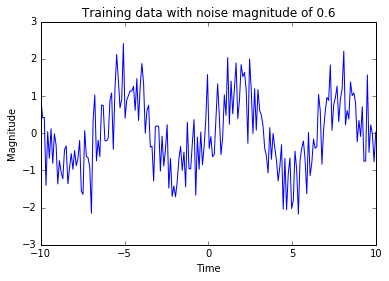

In [79]:
plt.plot(x, data)
plt.title('Training data with noise magnitude of '+ str(magRandNoise))
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.savefig('../graphs/Error_testing_spare/training_data_n_'+str(magRandNoise)+'.png')

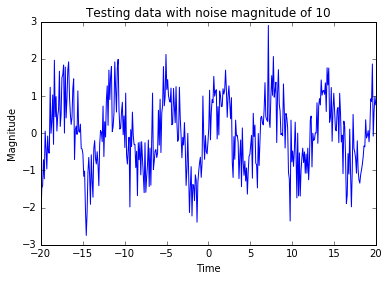

In [80]:
plt.plot(x2, data2)
plt.title('Testing data with noise magnitude of '+ str(magRandNoise2))
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.savefig('../graphs/Error_testing_spare/testing_data_n_'+str(magRandNoise2)+'.png')

The training dataset has been designed such it only represents half of the testing data. Both the extreme ends of the testing data only presented to the LSTM after training to observe the behaviour. The data here are sin curves added with random gaussian noise whose magnitude is decided during the dataset generation. Now we train the LSTM network using the training data and observe on the testing data.

In [82]:
lstmLayerWidth = 1
net = buildNetwork(1,lstmLayerWidth,1, hiddenclass=LSTMLayer, outputbias=False, recurrent=True)
#Training the network
trainer = RPropMinusTrainer(net, dataset= ds)
train_errors = []
state_values = [[] for k in range(lstmLayerWidth)]
epochs_per_cycle = 1
cycles = 50
epochs = epochs_per_cycle * cycles
for i in xrange(cycles):
    trainer.trainEpochs(epochs_per_cycle)
    train_errors.append(trainer.testOnData())
    epoch = (i+1) * epochs_per_cycle
    #print "\r epoch {}/{}".format(epoch, epochs)
state_values = [[] for k in range(lstmLayerWidth)]
state_val = list(net['hidden0'].state)[:len(data)]
for state in state_val:
    for k in range(lstmLayerWidth):
        state_values[k].append(state[k])
gen_state_iteration_plot(lstmLayerWidth,\
                state_values, net, ds2, i+1, 'sin_error_10mag', x2, save=True)

Error in prediction :0.522161216057


#### Gaussian Process generated data

In [91]:
#Generating the training data for the LSTM
L = 20
numPoints = 100
mean = np.zeros(numPoints)
vec = np.array([[j for j in range(0,numPoints)] for k in range(0,numPoints)])
covMat = np.exp(-(vec - vec.T)**2/float(L**2))
x = np.random.multivariate_normal(mean, covMat, size=(1,))
#generating random noise
magRandNoise = 0.1
noise = magRandNoise*np.random.rand(numPoints)
data = list(x[0] + noise)
ds = SequentialDataSet(1,1)
for sample, next_sample in zip(data, cycle(data[1:])):
    ds.addSample(sample, next_sample)

/Users/abhishek/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: covariance is not positive-semidefinite.


In [92]:
#Generating the training data for the LSTM
L2 = 20
numPoints2 = 200
mean2 = np.zeros(numPoints2)
vec2 = np.array([[j for j in range(0,numPoints2)] for k in range(0,numPoints2)])
covMat2 = np.exp(-(vec2 - vec2.T)**2/float(L2**2))
x2 = np.random.multivariate_normal(mean2, covMat2, size=(1,))
#generating random noise
magRandNoise2 = 1.0
noise2 = magRandNoise2*np.random.rand(numPoints2)
data2 = list(x2[0] + noise2)
ds2 = SequentialDataSet(1,1)
for sample, next_sample in zip(data2, cycle(data2[1:])):
    ds2.addSample(sample, next_sample)

/Users/abhishek/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: covariance is not positive-semidefinite.


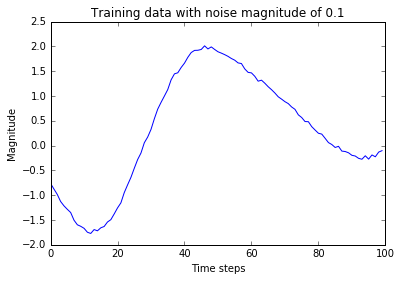

In [93]:
plt.plot(data)
plt.title('Training data with noise magnitude of '+ str(magRandNoise))
plt.xlabel('Time steps')
plt.ylabel('Magnitude')

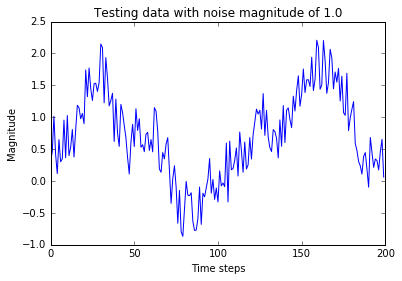

In [94]:
plt.plot(data2)
plt.title('Testing data with noise magnitude of '+ str(magRandNoise2))
plt.xlabel('Time steps')
plt.ylabel('Magnitude')

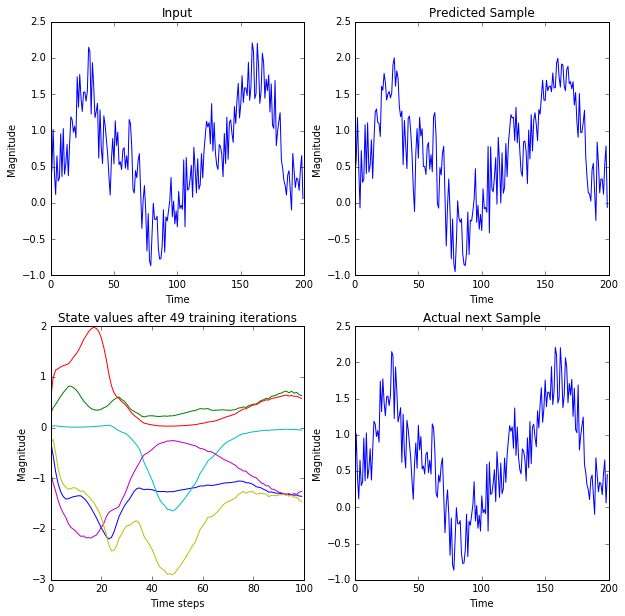

Error in prediction :0.170227768295


In [95]:
lstmLayerWidth = 5
net = buildNetwork(1,lstmLayerWidth,1, hiddenclass=LSTMLayer, outputbias=False, recurrent=True)
#Training the network
trainer = RPropMinusTrainer(net, dataset= ds)
train_errors = []
state_values = [[] for k in range(lstmLayerWidth)]
epochs_per_cycle = 1
cycles = 50
epochs = epochs_per_cycle * cycles
for i in xrange(cycles):
    trainer.trainEpochs(epochs_per_cycle)
    train_errors.append(trainer.testOnData())
    epoch = (i+1) * epochs_per_cycle
    #print "\r epoch {}/{}".format(epoch, epochs)
state_values = [[] for k in range(lstmLayerWidth)]
state_val = list(net['hidden0'].state)[:len(data)]
for state in state_val:
    for k in range(lstmLayerWidth):
        state_values[k].append(state[k])
gen_state_iteration_plot(lstmLayerWidth,\
                state_values, net, ds2, i, 'mv_gaussian', range(len(ds2)))